# Group 6 Internal Project

 This project is a real estate price predictor which involves GenAI, it's meant to help prospective buyers determine whether they are getting a "good deal"  on a house based on if it's listed price is above or below the price our model predicts for it.

# Exploratory Data Analysis

In [79]:
!pip3 install pandas
!pip3 install numpy
!pip3 install seaborn
!pip3 install scikit-learn
!pip2 install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("usa_real_estate.csv")

# 1. Quick overview
print("Shape:", df.shape)
print("\nColumn types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nSummary statistics for numeric columns:")
print(df.describe().T)

'pip2' is not recognized as an internal or external command,
operable program or batch file.


Shape: (1048575, 12)

Column types:
brokered_by       float64
status             object
price             float64
bed               float64
bath              float64
acre_lot          float64
street            float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
dtype: object

Missing values per column:
brokered_by         1038
status                 0
price               1090
bed               310006
bath              324968
acre_lot          178328
street              6776
city                 860
state                  7
zip_code             159
house_size        364886
prev_sold_date    550689
dtype: int64

Summary statistics for numeric columns:
                 count          mean           std  min        25%  \
brokered_by  1047537.0  5.187727e+04  3.039121e+04  0.0   23713.00   
price        1047485.0  4.774979e+05  2.774217e+06  0.0  120000.00   
bed           738569.0  3.309546e+00  1.598269

In [80]:
# 2. Unique values / basic checks for categoricals
print("\nStatus value counts:")
print(df['status'].value_counts(dropna=False).head(20))

print("\nTop 20 cities:")
print(df['city'].value_counts().head(20))

print("\nStates:")
print(df['state'].value_counts())

df.shape


Status value counts:
status
for_sale          1031598
ready_to_build      16977
Name: count, dtype: int64

Top 20 cities:
city
Chicago           12688
New York City      8248
Philadelphia       8206
Miami              6128
Jacksonville       5873
New York           5297
Brooklyn           5123
Naples             4630
Port Charlotte     4299
Cape Coral         4163
Lehigh Acres       4077
Washington         3883
Atlanta            3786
Baltimore          3466
Ocala              3124
Orlando            3080
Dallas             3057
Columbus           2806
Louisville         2743
Tampa              2658
Name: count, dtype: int64

States:
state
Florida                 163840
New York                 71399
North Carolina           58283
Illinois                 53432
Georgia                  52030
Pennsylvania             48885
Texas                    40111
Ohio                     37972
Tennessee                36650
Michigan                 36336
Virginia                 36087
New Jersey

(1048575, 12)

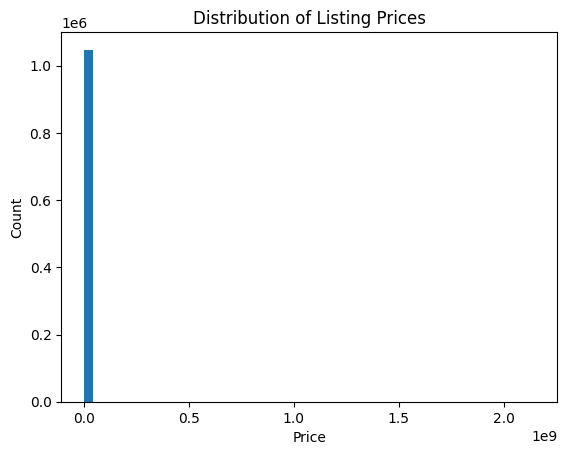

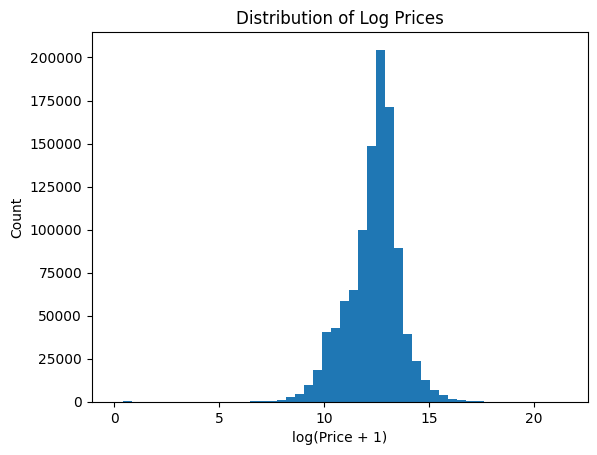

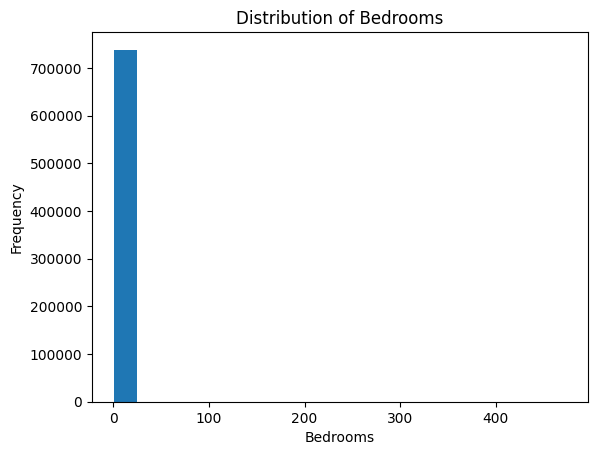

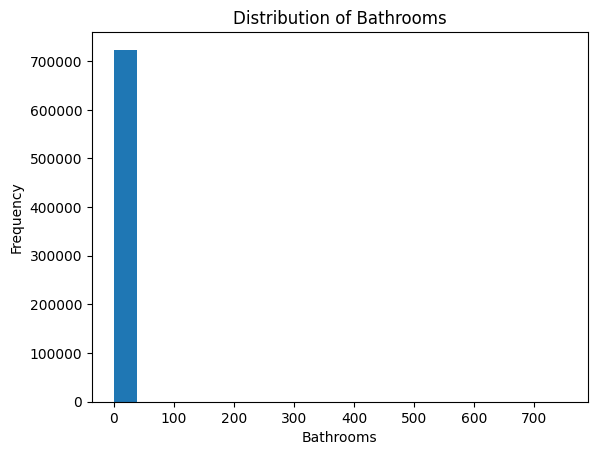

(1048575, 13)

In [81]:
# 3. Simple distributions

# Price distribution (use log to handle skew) (as housing prices are skweded, many cheap houses, few extremely expensive ones)
df['log_price'] = df['price'].apply(lambda x: np.log1p(x) if pd.notna(x) else x)

plt.figure()
df['price'].dropna().plot(kind='hist', bins=50)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Listing Prices")
plt.show()

plt.figure()
df['log_price'].dropna().plot(kind='hist', bins=50)
plt.xlabel("log(Price + 1)")
plt.ylabel("Count")
plt.title("Distribution of Log Prices")
plt.show()

# Beds and baths
plt.figure()
df['bed'].dropna().plot(kind='hist', bins=20)
plt.xlabel("Bedrooms")
plt.title("Distribution of Bedrooms")
plt.show()

plt.figure()
df['bath'].dropna().plot(kind='hist', bins=20)
plt.xlabel("Bathrooms")
plt.title("Distribution of Bathrooms")
plt.show()

df.shape

### Price vs House Size (Scatter Plot)

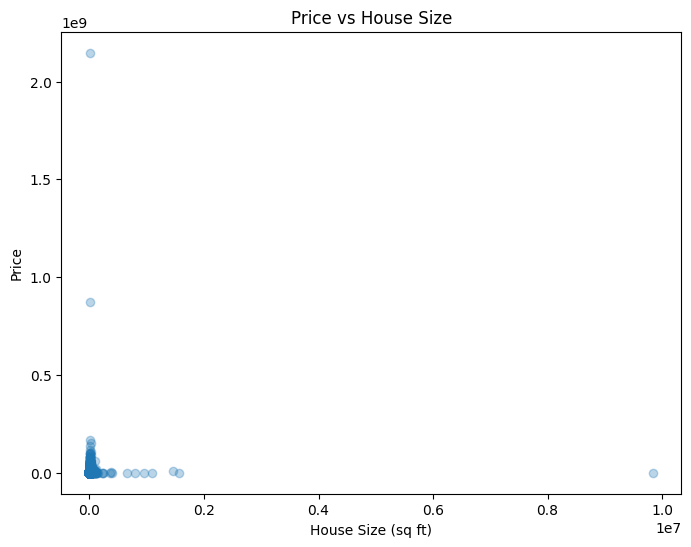

(683107, 2)

In [82]:
# Remove rows where house_size or price is missing
df_clean = df[['price', 'house_size']].dropna()

# Make a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['house_size'], df_clean['price'], alpha=0.3)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Price vs House Size")
plt.show()

df_clean.shape

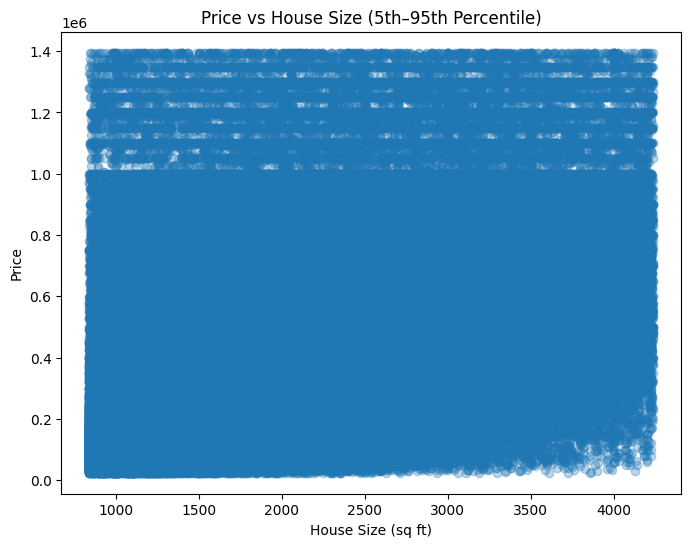

(591200, 13)

In [83]:
# Filter to remove extreme outliers
p_low = df['house_size'].quantile(0.05)
p_high = df['house_size'].quantile(0.95)

df_filtered = df[(df['house_size'] >= p_low) & (df['house_size'] <= p_high)]

# Filter price too
pr_low = df['price'].quantile(0.05)
pr_high = df['price'].quantile(0.95)

df_filtered = df_filtered[(df_filtered['price'] >= pr_low) & (df_filtered['price'] <= pr_high)]

plt.figure(figsize=(8,6))
plt.scatter(df_filtered['house_size'], df_filtered['price'], alpha=0.3)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Price vs House Size (5th–95th Percentile)")
plt.show()

df_filtered.shape


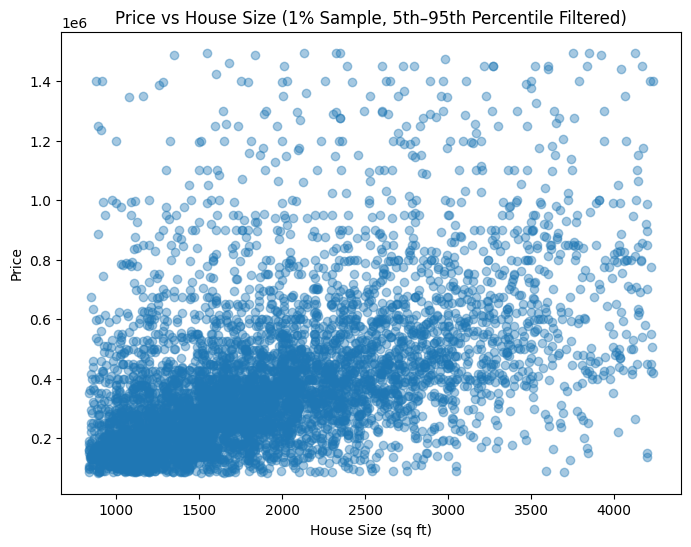

In [84]:
# Apply 5th–95th percentile filtering first
p_low_size = df_clean['house_size'].quantile(0.05)
p_high_size = df_clean['house_size'].quantile(0.95)

p_low_price = df_clean['price'].quantile(0.05)
p_high_price = df_clean['price'].quantile(0.95)

df_filtered = df_clean[
    (df_clean['house_size'] >= p_low_size) &
    (df_clean['house_size'] <= p_high_size) &
    (df_clean['price'] >= p_low_price) &
    (df_clean['price'] <= p_high_price)
]

# Take a 1% random sample
df_sample = df_filtered.sample(frac=0.01, random_state=42)

# Plot sampled scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(df_sample['house_size'], df_sample['price'], alpha=0.4)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Price vs House Size (1% Sample, 5th–95th Percentile Filtered)")
plt.show()

# Price does increase as house size increases
# Most homes fall between:
# 1,000–4,000 sq ft
# $150k – $600k
# The relationship is positive but noisy → size matters, but not the only factor (location, quality, etc.)

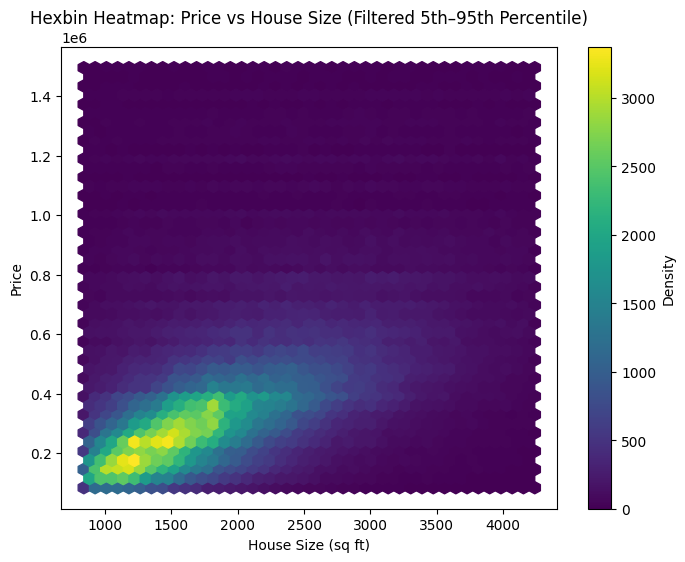

(567852, 2)

In [85]:
# Hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(df_filtered['house_size'], df_filtered['price'], gridsize=40)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Hexbin Heatmap: Price vs House Size (Filtered 5th–95th Percentile)")
plt.colorbar(label="Density")
plt.show()

# The bright yellow/green cluster shows that most homes are around: 1,200–2,000 sq ft & $150,000–$350,000
# The hexbin shape slopes upward, which shows, As house size increases → price increases

df_filtered.shape

state
District of Columbia    700000.0
Massachusetts           585000.0
Montana                 475000.0
Idaho                   454500.0
New Hampshire           439000.0
Delaware                409900.0
New York                399999.0
Virginia                399900.0
Virgin Islands          399000.0
Florida                 395900.0
Name: price, dtype: float64


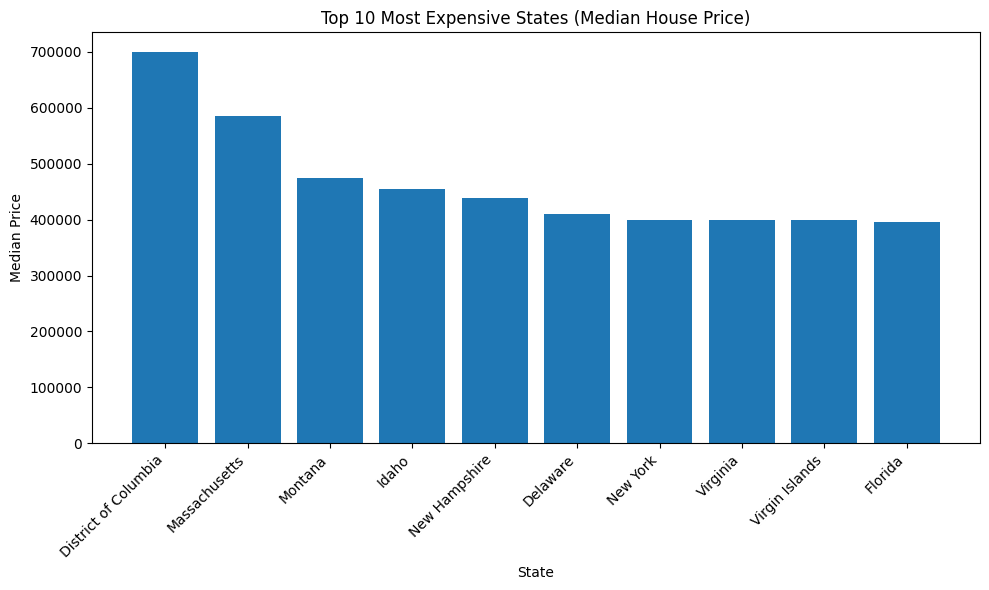

In [86]:
df_state = df[['state', 'price', 'house_size']].dropna()

#    for BOTH price and house_size – this is what keeps CA sane
p_low  = df_state['price'].quantile(0.05)
p_high = df_state['price'].quantile(0.95)
s_low  = df_state['house_size'].quantile(0.05)
s_high = df_state['house_size'].quantile(0.95)

df_state_filtered = df_state[
    (df_state['price'].between(p_low, p_high)) &
    (df_state['house_size'].between(s_low, s_high))
]

state_prices = (
    df_state_filtered
    .groupby('state')['price']
    .median()
    .sort_values(ascending=False)
)

top10 = state_prices.head(10)
print(top10)

# 6. Plot – this should look like your first screenshot
plt.figure(figsize=(10, 6))
plt.bar(top10.index, top10.values)
plt.xlabel("State")
plt.ylabel("Median Price")
plt.title("Top 10 Most Expensive States (Median House Price)")
plt.xticks(rotation=45, ha="right")
plt.ticklabel_format(style='plain', axis='y')  # remove 1e6 scientific notation
plt.tight_layout()
plt.show()

In [87]:
!pip install plotly
!pip install ipython nbformat>=4.2.0
import plotly.express as px
from IPython.display import HTML

# State name → abbreviation map
state_map = {
    'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA',
    'Colorado':'CO','Connecticut':'CT','Delaware':'DE','District of Columbia':'DC',
    'Florida':'FL','Georgia':'GA','Hawaii':'HI','Idaho':'ID','Illinois':'IL',
    'Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY','Louisiana':'LA',
    'Maine':'ME','Maryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN',
    'Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE','Nevada':'NV',
    'New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM','New York':'NY',
    'North Carolina':'NC','North Dakota':'ND','Ohio':'OH','Oklahoma':'OK',
    'Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC',
    'South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT',
    'Virginia':'VA','Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY',
    'Puerto Rico':'PR','Virgin Islands':'VI'
}

df['state_code'] = df['state'].map(state_map)

# Drop rows with unmapped states
df = df.dropna(subset=['state_code'])

# Keep needed columns
df_state = df[['state_code', 'price', 'house_size']].dropna()

# Percentile filtering
p_low_size = df_state['house_size'].quantile(0.05)
p_high_size = df_state['house_size'].quantile(0.95)
p_low_price = df_state['price'].quantile(0.05)
p_high_price = df_state['price'].quantile(0.95)

df_state_filtered = df_state[
    (df_state['house_size'] >= p_low_size) &
    (df_state['house_size'] <= p_high_size) &
    (df_state['price'] >= p_low_price) &
    (df_state['price'] <= p_high_price)
]

# Median price by state
state_prices = df_state_filtered.groupby('state_code')['price'].median().reset_index()

# Choropleth using state_code
fig = px.choropleth(
    state_prices,
    locations="state_code",
    locationmode="USA-states",
    color="price",
    color_continuous_scale="Viridis",
    scope="usa",
    labels={'price':'Median Price'},
    title="Median House Price by State (Choropleth Map)"
)

fig.show()

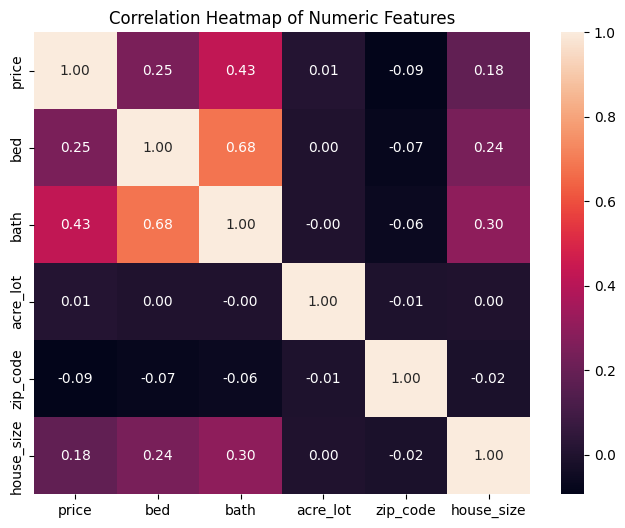

(526588, 6)

In [88]:
import seaborn as sns

# Select numeric columns only
numeric_df = df[['price', 'bed', 'bath', 'acre_lot', 'zip_code', 'house_size']].dropna()

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

numeric_df.shape


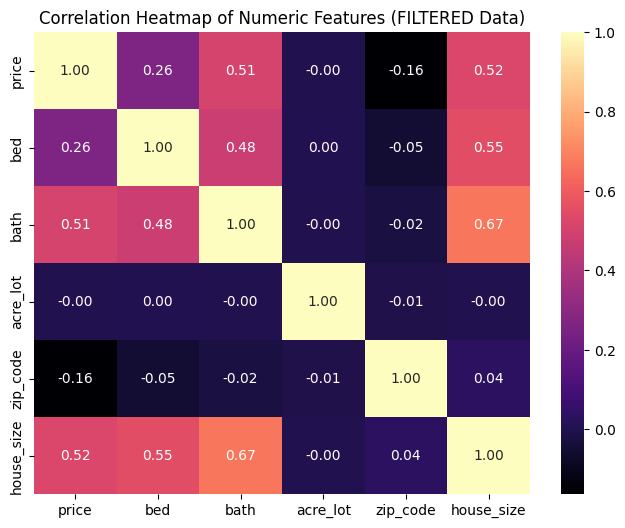

In [89]:
df_mod = df[['price', 'bed', 'bath', 'house_size', 'acre_lot', 'zip_code']].dropna()

# Apply 5th–95th percentile filtering
for col in ['price', 'house_size']:
    low = df_mod[col].quantile(0.05)
    high = df_mod[col].quantile(0.95)
    df_mod = df_mod[(df_mod[col] >= low) & (df_mod[col] <= high)]

# Step 3: Create numeric-only dataset
numeric_df = df_mod[['price', 'bed', 'bath', 'acre_lot', 'zip_code', 'house_size']]

# Step 4: Compute correlation matrix
corr_matrix = numeric_df.corr()

# Step 5: Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="magma")
plt.title("Correlation Heatmap of Numeric Features (FILTERED Data)")
plt.show()

In [90]:
df_sub = df[['price', 'state', 'city']].dropna()

# Apply percentile filtering on price to remove extreme outliers
p_low  = df_sub['price'].quantile(0.05)
p_high = df_sub['price'].quantile(0.95)

df_sub = df_sub[(df_sub['price'] >= p_low) & (df_sub['price'] <= p_high)]

# --- Correlation Ratio Function (η²) ---
def correlation_ratio(categories, measurements):
    categories = pd.Categorical(categories)
    cat_codes = categories.codes
    grand_mean = np.mean(measurements)
    ss_between = 0
    for cat in np.unique(cat_codes):
        group = measurements[cat_codes == cat]
        ss_between += len(group) * (np.mean(group) - grand_mean)**2
    ss_total = np.sum((measurements - grand_mean)**2)
    return ss_between / ss_total if ss_total != 0 else 0

# Compute correlation ratios
eta_state = correlation_ratio(df_sub['state'], df_sub['price'])
eta_city = correlation_ratio(df_sub['city'], df_sub['price'])

eta_state, eta_city

(np.float64(0.06975369590776247), np.float64(0.27900389069043324))

# Data Cleaning and Feature Engineering

This section prepares some of the columns and datatypes of the data for training our price prediction model.

In [91]:
# CELL 14 !!!!!!!
# view number of states and cities in dataset
print(f'no. of states in the dataset: {len(df['state'].unique())}')
print(f'no. of cities in the dataset: {len(df['city'].unique())}')

no. of states in the dataset: 46
no. of cities in the dataset: 15972


In [92]:
# checking for same city names in different states
freq = df.dropna(subset=['city', 'state_code']).groupby(['city', 'state_code']).size().reset_index(name = 'count')
freq['city'] = freq['city'].str.strip().str.title().str.lower()
freq['state_code'] = freq['state_code'].str.strip().str.upper()
freq['city_state'] = freq['city'] + "_" + freq["state_code"]
n_combi = freq.shape[0]

print(f"There is a total of {n_combi} city-state combinations")

There is a total of 24078 city-state combinations


In [93]:
# removing null values from important columns
no_null = ['price', 'house_size', 'bed', 'bath', 'acre_lot', 'state', 'city']
new_df = df.copy()
new_df = new_df.dropna(subset = no_null)

new_df.shape

# # After dropping null values some of the states and cities are no longer in our dataset
print(f'no. of states left in the dataset post dropping null values: {len(new_df['state'].unique())}')
print(f'no. of cities left in the dataset post dropping null values: {len(new_df['city'].unique())}')


no. of states left in the dataset post dropping null values: 46
no. of cities left in the dataset post dropping null values: 13526


In [94]:
# Data Cleaning
for cols in new_df.columns:
    if cols == "price" or cols=="house_size":
        low = new_df[cols].quantile(0.05)
        high = new_df[cols].quantile(0.95)
        new_df = new_df[(new_df[cols] >= low) & (new_df[cols] <= high)]
    elif cols == "bed" or cols == "bath" or cols == "acre_lot":
        low = new_df[cols].quantile(0.01)
        high = new_df[cols].quantile(0.99)
        new_df = new_df[(new_df[cols] >= low) & (new_df[cols] <= high)]
    else:
        continue

new_df.shape

(415351, 14)

In [95]:
bath_bed = new_df['bath'] > new_df['bed']*2

print(f"Within the filtered data, there are {bath_bed.sum()} number of houses with more bathrooms than bedrooms")
print()
df_view = new_df[bath_bed]
print(df_view[['bed', 'bath']])

Within the filtered data, there are 95 number of houses with more bathrooms than bedrooms

         bed  bath
5936     1.0   4.0
20719    1.0   3.0
21423    2.0   5.0
29195    1.0   3.0
30303    1.0   4.0
...      ...   ...
950611   1.0   3.0
979619   1.0   3.0
980046   1.0   3.0
1029584  1.0   3.0
1033862  1.0   3.0

[95 rows x 2 columns]


In [96]:
# drop rows with bathrooms > 2* the number of bedrooms
new_df = new_df[~bath_bed]

# Check shape after dropping
print(new_df.shape)

(415256, 14)


In [97]:
new_df

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,log_price,state_code
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN,11.289794,PR
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN,11.884496,PR
5,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN,12.095147,PR
8,81909.0,for_sale,100000.0,2.0,1.0,0.09,734904.0,Ponce,Puerto Rico,730.0,1092.0,NaN,11.512935,PR
10,52707.0,for_sale,89000.0,3.0,2.0,13.39,1902814.0,Isabela,Puerto Rico,662.0,1106.0,NaN,11.396403,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048568,3873.0,for_sale,508620.0,4.0,3.0,0.39,812581.0,Harker Heights,Texas,76548.0,2595.0,NaN,13.139458,TX
1048569,3873.0,for_sale,523171.0,4.0,3.0,0.40,828186.0,Harker Heights,Texas,76548.0,2629.0,NaN,13.167666,TX
1048570,68915.0,for_sale,467847.0,5.0,4.0,0.19,773587.0,Harker Heights,Texas,76548.0,3499.0,NaN,13.055899,TX
1048571,68915.0,for_sale,345249.0,5.0,3.0,0.19,772323.0,Harker Heights,Texas,76548.0,2572.0,NaN,12.752024,TX


In [98]:
# After dropping null values some of the states and cities are no longer in our dataset
print(f'no. of states left in the dataset post dropping null values and removing outliers: {len(new_df['state'].unique())}')
print(f'no. of cities left in the dataset post dropping null values and removing outliers: {len(new_df['city'].unique())}')
print(new_df.shape)

no. of states left in the dataset post dropping null values and removing outliers: 45
no. of cities left in the dataset post dropping null values and removing outliers: 12438
(415256, 14)


In [99]:
# drop unused / columns irrelevant to the model and may reduce accuracy in price prediction.
new_df = new_df.drop(['brokered_by', 'status', 'street', 'prev_sold_date','log_price', 'zip_code'], axis = 1)
new_df.shape

# Feature 1 - converting acre lot to square foot and renaming it as lot_size for clarity
new_df = new_df.rename(columns={'acre_lot' : 'lot_size'})
new_df['lot_size'] = new_df['lot_size'] * 43560
new_df

,price,bed,bath,lot_size,city,state,house_size,state_code
1,80000.0,4.0,2.0,3484.8,Adjuntas,Puerto Rico,1527.0,PR
3,145000.0,4.0,2.0,4356.0,Ponce,Puerto Rico,1800.0,PR
5,179000.0,4.0,3.0,20037.6,San Sebastian,Puerto Rico,2520.0,PR
8,100000.0,2.0,1.0,3920.4,Ponce,Puerto Rico,1092.0,PR
10,89000.0,3.0,2.0,583268.4,Isabela,Puerto Rico,1106.0,PR
...,...,...,...,...,...,...,...,...
1048568,508620.0,4.0,3.0,16988.4,Harker Heights,Texas,2595.0,TX
1048569,523171.0,4.0,3.0,17424.0,Harker Heights,Texas,2629.0,TX
1048570,467847.0,5.0,4.0,8276.4,Harker Heights,Texas,3499.0,TX
1048571,345249.0,5.0,3.0,8276.4,Harker Heights,Texas,2572.0,TX


In [100]:
# Dropping null values
new_df = new_df.dropna()
new_df.describe()

,price,bed,bath,lot_size,house_size
count,4.152560e+05,415256.000000,415256.000000,4.152560e+05,415256.000000
mean,3.745006e+05,3.360525,2.435803,4.175053e+04,1967.235821
std,2.183948e+05,0.832330,0.840362,1.184667e+05,660.922654
min,8.000000e+04,1.000000,1.000000,8.712000e+02,960.000000
25%,2.200000e+05,3.000000,2.000000,6.534000e+03,1447.000000
50%,3.250000e+05,3.000000,2.000000,1.089000e+04,1844.000000
75%,4.690000e+05,4.000000,3.000000,2.265120e+04,2396.000000
max,1.385000e+06,7.000000,5.000000,1.478426e+06,3768.000000


In [101]:
# After dropping null values some of the states and cities are no longer in our dataset
print(f'no. of states left in the dataset post dropping null values: {len(new_df['state'].unique())}')
print(f'no. of cities left in the dataset post dropping null values: {len(new_df['city'].unique())}')

no. of states left in the dataset post dropping null values: 45
no. of cities left in the dataset post dropping null values: 12438


In [102]:
# # feature 2 - average price per square foot for each city (using city_state combination)
# new_df = new_df.copy()
# new_df['city_state'] = new_df['city'] + '_' + new_df['state_code']
# new_df['city_avg_ppsqft'] = new_df.groupby('city_state')['price'].transform('sum') / new_df.groupby('city_state')['house_size'].transform('sum')

# # calculate individual property's price per square feet for comparison
# new_df['price_per_sqft'] = new_df['price'] / new_df['house_size']
# new_df['ppsqft_vs_city_avg'] = new_df['price_per_sqft'] / new_df['city_avg_ppsqft']

# new_df.drop(columns = ['price_per_sqft', 'city_avg_ppsqft'])

In [103]:
import pickle
# feature 2 - average price per square foot for each city (using city_state combination)
new_df = new_df.copy()
new_df['city_state'] = new_df['city'] + '_' + new_df['state_code']
new_df['city_avg_ppsqft'] = new_df.groupby('city_state')['price'].transform('sum') / new_df.groupby('city_state')['house_size'].transform('sum')

# calculate individual property's price per square feet for comparison
new_df['price_per_sqft'] = new_df['price'] / new_df['house_size']
new_df['ppsqft_vs_city_avg'] = new_df['price_per_sqft'] / new_df['city_avg_ppsqft']

city_avg_lookup = new_df.groupby('city_state')['city_avg_ppsqft'].first().to_dict()

with open('city_avg_ppsqft.pkl', 'wb') as f:
    pickle.dump(city_avg_lookup, f)

new_df.drop(columns = ['price_per_sqft', 'city_avg_ppsqft'])

,price,bed,bath,lot_size,city,state,house_size,state_code,city_state,ppsqft_vs_city_avg
1,80000.0,4.0,2.0,3484.8,Adjuntas,Puerto Rico,1527.0,PR,Adjuntas_PR,1.000000
3,145000.0,4.0,2.0,4356.0,Ponce,Puerto Rico,1800.0,PR,Ponce_PR,0.690800
5,179000.0,4.0,3.0,20037.6,San Sebastian,Puerto Rico,2520.0,PR,San Sebastian_PR,0.667576
8,100000.0,2.0,1.0,3920.4,Ponce,Puerto Rico,1092.0,PR,Ponce_PR,0.785297
10,89000.0,3.0,2.0,583268.4,Isabela,Puerto Rico,1106.0,PR,Isabela_PR,0.432797
...,...,...,...,...,...,...,...,...,...,...
1048568,508620.0,4.0,3.0,16988.4,Harker Heights,Texas,2595.0,TX,Harker Heights_TX,1.329113
1048569,523171.0,4.0,3.0,17424.0,Harker Heights,Texas,2629.0,TX,Harker Heights_TX,1.349457
1048570,467847.0,5.0,4.0,8276.4,Harker Heights,Texas,3499.0,TX,Harker Heights_TX,0.906705
1048571,345249.0,5.0,3.0,8276.4,Harker Heights,Texas,2572.0,TX,Harker Heights_TX,0.910264


In [131]:
new_df['ppsqft_vs_city_avg'].nlargest(20)

978884     7.991180
795261     7.758261
894321     7.750181
660551     7.616823
761640     7.274116
932087     7.029683
403439     6.648966
586819     6.550077
402152     6.473826
576308     6.262685
749577     6.253217
742890     6.203698
671468     6.147920
670599     6.034069
396782     5.973263
1002459    5.961783
1028897    5.939821
730677     5.718583
572209     5.646967
207716     5.643578
Name: ppsqft_vs_city_avg, dtype: float64

In [104]:
# import pickle
# # After creating the city_avg_ppsqft feature in your training data
# city_avg_lookup = new_df.groupby('city_state').agg({
#     'price': 'sum',
#     'house_size': 'sum'
# }).reset_index()
# city_avg_lookup['city_avg_ppsqft'] = city_avg_lookup['price'] / city_avg_lookup['house_size']
# city_avg_lookup = city_avg_lookup[['city_state', 'city_avg_ppsqft']].set_index('city_state')['city_avg_ppsqft'].to_dict()

# with open('city_avg_ppsqft_lookup.pkl', 'wb') as f:
#     pickle.dump(city_avg_lookup, f)

# Model Selection & Training

In this section we test two models (Gradient Boost and XGBoost) for accuracy and train our dataset on the most accurate one.

In [105]:
# Imports
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from category_encoders import TargetEncoder
import pickle

In [106]:
# Splitting data into train and test
# Features
X = new_df[['house_size', 'bed', 'bath', 'city', 'state', 'lot_size', 'ppsqft_vs_city_avg']]

# Target
y = new_df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

# Reset indices to align with sequential integers (0, 1, 2, ...)
X_train_reset = X_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

X_train.shape, X_test.shape
y_train.shape, y_test.shape


((332204,), (83052,))

In [107]:
# # --- TARGET ENCODING SETUP ---

# target_column_city = ['city']
# target_column_state = ['state']
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # X_encoded will hold the training data with encoded features
# X_encoded = X_train_reset.copy()
# city_encoder = TargetEncoder(cols=target_column_city, smoothing=1.0)
# state_encoder = TargetEncoder(cols=target_column_state, smoothing=1.0)

# # --- TARGET ENCODING WITH K-FOLD CROSS-VALIDATION ---

# # City Encoding Loop
# for train_index, val_index in kf.split(X_train_reset):
#     X_train_fold = X_train_reset.loc[train_index]
#     y_train_fold = y_train_reset.loc[train_index]
#     X_val_fold = X_train_reset.loc[val_index]

#     city_encoder.fit(X_train_fold, y_train_fold)
#     X_encoded.loc[val_index, 'city_encoded'] = city_encoder.transform(X_val_fold)[target_column_city].iloc[:, 0]

# # State Encoding Loop
# for train_index, val_index in kf.split(X_train_reset):
#     X_train_fold = X_train_reset.loc[train_index]
#     y_train_fold = y_train_reset.loc[train_index]
#     X_val_fold = X_train_reset.loc[val_index]

#     state_encoder.fit(X_train_fold, y_train_fold)
#     X_encoded.loc[val_index, 'state_encoded'] = state_encoder.transform(X_val_fold)[target_column_state].iloc[:, 0]

# # --- FINAL ENCODER FIT ON ALL TRAINING DATA ---

# # These encoders will be used for test set transformation and future predictions
# final_city_encoder = TargetEncoder(cols=target_column_city, smoothing=1.0)
# final_city_encoder.fit(X_train_reset, y_train_reset)

# final_state_encoder = TargetEncoder(cols=target_column_state, smoothing=1.0)
# final_state_encoder.fit(X_train_reset, y_train_reset)

# # --- PREPARE FINAL TRAINING FEATURES ---

# X_train_final = X_encoded.drop(columns=['city', 'state'])

# # --- PREPARE FINAL TEST FEATURES ---

# X_test_reset = X_test.reset_index(drop=True)
# y_test_reset = y_test.reset_index(drop = True)

# # Apply the final fitted encoders to test set
# # Important: Transform the original data for both encoders BEFORE adding any new columns
# city_encoded = final_city_encoder.transform(X_test_reset)[target_column_city].iloc[:, 0]
# state_encoded = final_state_encoder.transform(X_test_reset)[target_column_state].iloc[:, 0]

# # Now add both encoded columns to the dataframe
# X_test_reset['city_encoded'] = city_encoded
# X_test_reset['state_encoded'] = state_encoded

# # Create the final clean test feature set
# X_test_final = X_test_reset.drop(columns=['city', 'state'])

# # --- SAVE ENCODERS FOR FUTURE USE ---

# with open('final_city_encoder.pkl', 'wb') as file:
#     pickle.dump(final_city_encoder, file)
# with open('final_state_encoder.pkl', 'wb') as file:
#     pickle.dump(final_state_encoder, file)

In [108]:
X_train_reset

,house_size,bed,bath,city,state,lot_size,ppsqft_vs_city_avg
0,1801.0,3.0,3.0,Dalton,Georgia,7405.2,0.890197
1,980.0,2.0,1.0,Gallatin,New York,1097712.0,0.994433
2,1976.0,4.0,2.0,Lake Placid,Florida,217800.0,1.137407
3,2643.0,4.0,3.0,Surf City,North Carolina,6969.6,0.551821
4,1110.0,2.0,1.0,Nags Head,North Carolina,6534.0,1.360694
...,...,...,...,...,...,...,...
332199,1061.0,2.0,1.0,Toledo,Ohio,4791.6,1.082918
332200,1989.0,5.0,3.0,Derby,Kansas,9583.2,1.329186
332201,1320.0,4.0,2.0,Conway,South Carolina,15681.6,1.193796
332202,2140.0,2.0,3.0,Atlanta,Georgia,2178.0,1.027200


In [109]:
# Feature 3 - Target encoding for state and city_state
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

X_train_reset['city_state'] = X_train_reset['city'].astype(str) + "_" + X_train_reset['state'].astype(str)
X_test_reset['city_state'] = X_test_reset['city'].astype(str) + "_" + X_test_reset['state'].astype(str)

# setting target columns
target_column_city = ['city_state']
target_column_state = ['state']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# copy of training data to hold encoded columns
X_encoded = X_train_reset.copy()

for train_idx, val_idx in kf.split(X_train_reset):
    X_fold_train = X_train_reset.loc[train_idx, ['city_state']].copy()
    y_fold_train = y_train_reset.loc[train_idx]
    X_val_fold = X_train_reset.loc[val_idx, ['city_state']].copy()

    city_encoder = TargetEncoder(cols=target_column_city, smoothing=1.0)
    city_encoder.fit(X_fold_train, y_fold_train)

    # Transform validation fold and store in main X_encoded
    X_encoded.loc[val_idx, 'city_encoded'] = city_encoder.transform(X_val_fold)['city_state']

for train_idx, val_idx in kf.split(X_train_reset):
    X_fold_train = X_train_reset.loc[train_idx, ['state']].copy()
    y_fold_train = y_train_reset.loc[train_idx]
    X_val_fold = X_train_reset.loc[val_idx, ['state']].copy()

    city_encoder = TargetEncoder(cols=target_column_state, smoothing=1.0)
    city_encoder.fit(X_fold_train, y_fold_train)

    # Transform validation fold and store in main X_encoded
    X_encoded.loc[val_idx, 'state_encoded'] = city_encoder.transform(X_val_fold)['state']

final_city_encoder = TargetEncoder(cols=['city_state'], smoothing=1.0)
final_city_encoder.fit(X_train_reset[['city_state']], y_train_reset)

final_state_encoder = TargetEncoder(cols=['state'], smoothing=1.0)
final_state_encoder.fit(X_train_reset[['state']], y_train_reset)

X_test_city_encoded = final_city_encoder.transform(X_test_reset[['city_state']])['city_state']
X_test_state_encoded = final_state_encoder.transform(X_test_reset[['state']])['state']

X_test_reset['city_encoded'] = X_test_city_encoded
X_test_reset['state_encoded'] = X_test_state_encoded

# drop categorical columns
X_train_final = X_encoded.drop(columns=['city', 'state','city_state'])
X_test_final = X_test_reset.drop(columns=['city', 'state', 'city_state'])


with open('final_city_encoder.pkl', 'wb') as f:
    pickle.dump(final_city_encoder, f)
with open('final_state_encoder.pkl', 'wb') as f:
    pickle.dump(final_state_encoder, f)

# Now X_train_final and X_test_final have 7 columns: 
# house_size, bed, bath, lot_size, ppsqft_vs_city_avg, city_encoded, state_encoded

In [110]:
X_test_final

,house_size,bed,bath,lot_size,ppsqft_vs_city_avg,city_encoded,state_encoded
0,3744.0,7.0,3.0,12632.4,0.549357,235570.075269,429952.104445
1,1472.0,3.0,1.0,9583.2,0.772802,228513.295623,404808.091719
2,1165.0,4.0,1.0,7405.2,1.364760,235491.237500,429952.104445
3,3300.0,4.0,4.0,4791.6,1.024917,635549.500000,429952.104445
4,2210.0,4.0,3.0,40946.4,0.999476,296741.944444,307290.743920
...,...,...,...,...,...,...,...
83047,2156.0,4.0,3.0,30056.4,1.182514,517020.757827,429952.104445
83048,2458.0,4.0,3.0,44866.8,0.859181,542231.150502,437954.430525
83049,1373.0,3.0,2.0,6098.4,0.729730,580966.768293,463511.250846
83050,968.0,3.0,1.0,10018.8,1.140873,162962.280345,447018.399414


In [111]:
city_state_map = X_encoded[['city', 'state', 'city_encoded']]

# Group by both city and state and get mean encoded value
city_state_summary = (
    city_state_map
    .groupby(['city', 'state'])['city_encoded']
    .mean()
    .reset_index()
    .sort_values(by='city_encoded', ascending=False)
)

# Display top 20 city-states
print("="*60)
print("TOP 20 MOST EXPENSIVE CITY-STATES (Highest Encoded Values)")
print("="*60)
for i, row in enumerate(city_state_summary.head(20).itertuples(index=False), 1):
    print(f"{i:<2d}. {row.city:<25s} {row.state:<15s} ${row.city_encoded:<,.2f}")

# Display bottom 20 city-states
print("\n" + "="*60)
print("BOTTOM 20 CHEAPEST CITY-STATES (Lowest Encoded Values)")
print("="*60)
for i, row in enumerate(city_state_summary.tail(20).sort_values('city_encoded').itertuples(index=False), 1):
    print(f"{i:<2d}. {row.city:<25s} {row.state:<15s} ${row.city_encoded:<,.2f}")


# # Find the actual highest city_encoded value
# city_encoding_map = X_train_reset[['city']].copy()
# city_encoding_map['city_state_encoded'] = X_encoded['city_state_encoded']

# # Get unique cities with their encoded values
# city_summary = city_encoding_map.groupby('city')['city_encoded'].mean().sort_values(ascending=False)

# print("="*60)
# print("TOP 20 MOST EXPENSIVE CITIES (Highest Encoded Values)")
# print("="*60)
# for i, (city, value) in enumerate(city_summary.head(20).items(), 1):
#     print(f"{i:2d}. {city:30s} ${value:,.2f}")

# print("\n" + "="*60)
# print("BOTTOM 20 CHEAPEST CITIES (Lowest Encoded Values)")
# print("="*60)
# for i, (city, value) in enumerate(city_summary.tail(20).items(), 1):
#     print(f"{i:2d}. {city:30s} ${value:,.2f}")


# Find the actual highest city_encoded value
state_encoding_map = X_train_reset[['state']].copy()
state_encoding_map['state_encoded'] = X_encoded['state_encoded']

# Get unique cities with their encoded values
state_summary = state_encoding_map.groupby('state')['state_encoded'].mean().sort_values(ascending=False)

print("="*60)
print("TOP 20 MOST EXPENSIVE STATES (Highest Encoded Values)")
print("="*60)
for i, (state, value) in enumerate(state_summary.head(20).items(), 1):
    print(f"{i:<2d}. {state:<30s} ${value:<,.2f}")

print("\n" + "="*60)
print("BOTTOM 20 CHEAPEST STATES (Lowest Encoded Values)")
print("="*60)
for i, (state, value) in enumerate(state_summary.tail(20).items(), 1):
    print(f"{i:2d}. {state:30s} ${value:,.2f}")

TOP 20 MOST EXPENSIVE CITY-STATES (Highest Encoded Values)
1 . Flushing                  New York        $1,028,177.89
2 . Key West                  Florida         $1,013,797.76
3 . Bethesda                  Maryland        $1,001,481.74
4 . New York City             New York        $999,829.02
5 . Madeira Beach             Florida         $991,906.89
6 . Palmetto Bay              Florida         $988,547.44
7 . Coral Gables              Florida         $967,552.21
8 . Ocean City                New Jersey      $959,913.28
9 . Arlington                 Virginia        $943,798.89
10. Saint George Island       Florida         $932,815.23
11. Parkland                  Florida         $930,391.56
12. Potomac                   Maryland        $917,992.16
13. Princeton                 New Jersey      $914,443.93
14. Vienna                    Virginia        $912,092.12
15. Brooklyn                  New York        $908,409.44
16. Indialantic               Florida         $866,961.90
17. Fal

In [112]:
# checking for any data leakage or leftover outliers by comparing train and test datasets
print("Target Distribution Comparison:")
print('-'*50)
print(f"Train target mean: {y_train_reset.mean():,.2f}")
print(f"Test target mean:  {y_test_reset.mean():,.2f}")
print(f"Train target std:  {y_train_reset.std():,.2f}")
print(f"Test target std:   {y_test_reset.std():,.2f}")
print(f"Train target min:  {y_train_reset.min():,.2f}")
print(f"Train target max:  {y_train_reset.max():,.2f}")
print(f"Test target min:   {y_test_reset.min():,.2f}")
print(f"Test target max:   {y_test_reset.max():,.2f}")

# checking baselines as basis to check model's performance
baseline_pred = np.full(len(y_test_reset), y_train_reset.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test_reset, baseline_pred))
baseline_mae = mean_absolute_error(y_test_reset, baseline_pred)
print("\nBaseline Model (Mean):")
print('-'*50)
print(f"Baseline RMSE: {baseline_rmse:,.2f}")
print(f"Baseline MAE:  {baseline_mae:,.2f}")

# Feature statistics comparison
print("\nComparison per features:")
print('-'*50)
for col in X_train_final.columns:  
    print(f"{col}:")
    print(f"Train mean: {X_train_final[col].mean():.4f}  Test mean: {X_test_final[col].mean():.4f}")
    print(f"Train std:  {X_train_final[col].std():.4f}  Test std:  {X_test_final[col].std():.4f}")
print()
print("Columns in X_train_final:")
print(X_train_final.columns.tolist())

Target Distribution Comparison:
--------------------------------------------------
Train target mean: 374,378.97
Test target mean:  374,987.16
Train target std:  218,555.77
Test target std:   217,750.35
Train target min:  80,000.00
Train target max:  1,385,000.00
Test target min:   80,000.00
Test target max:   1,385,000.00

Baseline Model (Mean):
--------------------------------------------------
Baseline RMSE: 217,749.89
Baseline MAE:  163,093.82

Comparison per features:
--------------------------------------------------
house_size:
Train mean: 1967.5216  Test mean: 1966.0927
Train std:  661.8346  Test std:  657.2651
bed:
Train mean: 3.3603  Test mean: 3.3613
Train std:  0.8335  Test std:  0.8275
bath:
Train mean: 2.4356  Test mean: 2.4365
Train std:  0.8408  Test std:  0.8385
lot_size:
Train mean: 41684.6138  Test mean: 42014.1686
Train std:  118361.9453  Test std:  118885.1546
ppsqft_vs_city_avg:
Train mean: 1.0133  Test mean: 1.0146
Train std:  0.3233  Test std:  0.3237
city_encod

### Hyperparameter Tuning and Model Training

In [113]:
# models = {
#     'GradientBoosting': GradientBoostingRegressor(random_state=42),
#     'XGBoost': XGBRegressor(random_state=42, eval_metric='rmse', tree_method='hist'),
# }

# param_grid = {
#     'GradientBoosting': {
#         'model__n_estimators': [150, 200, 250],
#         'model__learning_rate': [0.05],              
#         'model__max_depth': [3, 4, 5],                     
#         'model__min_samples_split': [15, 25],    
#         'model__min_samples_leaf': [10, 20],
#     },
#     'XGBoost': {
#         'model__n_estimators': [200, 250, 350],
#         'model__learning_rate': [0.05],
#         'model__max_depth': [3,4,5],                 
#         'model__min_child_weight': [30, 50, 80],
#         'model__gamma': [0.5, 2],
#     }
# }

In [114]:
# models = {
#     'RandomForest': RandomForestRegressor(random_state = 42),
#     'GradientBoosting': GradientBoostingRegressor(random_state=42),
#     'XGBoost': XGBRegressor(random_state=42, eval_metric='rmse', tree_method='hist'),
# }

# param_grid = {
#     'RandomForest': {
#         'model__n_estimators': [200, 250],              
#         'model__max_depth': [5,10],
#     },
#     'GradientBoosting': {
#         'model__n_estimators': [200, 250],
#         'model__learning_rate': [0.05, 0.07],              
#         'model__max_depth': [5, 6],                     
#         'model__min_samples_split': [25],    
#         'model__min_samples_leaf': [10, 15],
#     },
#     'XGBoost': {
#         'model__n_estimators': [300,350],
#         'model__learning_rate': [0.05, 0.07],
#         'model__max_depth': [5],                  
#         'model__min_child_weight': [50, 75],
#         'model__gamma': [0.5],
#         'model__subsample': [0.8,1.0]
#     }
# }

In [115]:
# models = {
#     'RandomForest': RandomForestRegressor(random_state = 42),
#     'GradientBoosting': GradientBoostingRegressor(random_state=42),
#     'XGBoost': XGBRegressor(random_state=42, eval_metric='rmse', tree_method='hist'),
# }

# param_grid = {
#     # 'RandomForest': {
#     #     'model__n_estimators': [200, 250],              
#     #     'model__max_depth': [8, 10, 12],
#     #     'model__min_samples_leaf': [5, 10, 15],
#     # },
#     # 'GradientBoosting': {
#     #     'model__n_estimators': [250, 300, 350],
#     #     'model__learning_rate': [0.05],              
#     #     'model__max_depth': [4, 5, 6],                     
#     #     'model__min_samples_split': [25, 30],    
#     #     'model__min_samples_leaf': [10, 15],
#     # },
#     'XGBoost': {
#         'model__n_estimators': [300, 350, 450],
#         'model__learning_rate': [0.05, 0.07],
#         'model__max_depth': [4, 5],                  
#         'model__min_child_weight': [50, 75],
#         'model__gamma': [0.5, 0.7],
#         'model__subsample': [0.8, 1.0]
#     }
# }

In [116]:
models = {
    'RandomForest': RandomForestRegressor(random_state = 42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, eval_metric='rmse', tree_method='hist'),
}

param_grid = {
    'RandomForest': {
        'model__n_estimators': [200, 250],              
        'model__max_depth': [8, 10, 12],
        'model__min_samples_leaf': [5, 10, 15],
    },
    'GradientBoosting': {
        'model__n_estimators': [250, 300, 350],
        'model__learning_rate': [0.05],              
        'model__max_depth': [4, 5, 6],                     
        'model__min_samples_split': [25, 30],    
        'model__min_samples_leaf': [10, 15],
    },
    'XGBoost': {
        'model__n_estimators': [400, 450],
        'model__learning_rate': [0.05, 0.07],
        'model__max_depth': [4, 5],                  
        'model__min_child_weight': [50, 75],
        'model__gamma': [0.5, 0.7],
        'model__subsample': [0.8, 1.0]
    }
}

In [117]:
tuned_metrics = {}
tuned_details = {}
best_models = {}
best_params = {}

# start model training and hyperparameter tuning
for name, model in models.items():
    print(f"Tuning {name}...\n")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid[name],
        cv=3,
        scoring=['neg_mean_squared_error','neg_mean_absolute_error'],
        refit='neg_mean_squared_error',
        return_train_score=True,
        n_jobs=-1,
        error_score='raise',
    )
    
    # train model using grid search, with training dataset
    gs.fit(X_train_final, y_train_reset)
    best_pipeline = gs.best_estimator_
    best_models[name] = best_pipeline
    best_params[name] = gs.best_params_ 
    
    # evaluate performance of each hyperparameter combination, done to facilitate comparison between train and test scores
    results = gs.cv_results_
    params = results['params']
    train_rmse = (-results['mean_train_neg_mean_squared_error']) ** 0.5
    train_mae = (-results['mean_train_neg_mean_absolute_error'])
    
    test_rmse = []
    test_mae = []
    for i, p in enumerate(params):
        # setting pipeline to the specific hyperparameter combination
        pipeline.set_params(**p)
        pipeline.fit(X_train_final, y_train_reset)
        test_preds = pipeline.predict(X_test_final)

        # evaluate model prediction performance on test set
        rmse = root_mean_squared_error(y_test_reset, test_preds)
        mae = mean_absolute_error(y_test_reset, test_preds)
        r2 = r2_score(y_test_reset, test_preds)
        test_rmse.append(rmse)
        test_mae.append(mae)
        
        print(f"Combination {i+1}: {p}")
        print(f"Train RMSE = {train_rmse[i]:,.2f}   Train MAE = {train_mae[i]:,.2f}")
        print(f"Test RMSE = {rmse:,.2f}   Test MAE = {mae:,.2f}")
        print(f"Test r2 = {r2:,.2f}")
        print("-"*50)
    
    # Store detailed results in dataframe
    df_metrics = pd.DataFrame({
        "params": params,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
    })
    tuned_details[name] = df_metrics
    
    # finding the index of the best (lowest) test RMSE
    best_idx = np.argmin(test_rmse)
    best_rmse = test_rmse[best_idx]
    best_mae = test_mae[best_idx]
    tuned_metrics[name] = {'rmse': best_rmse, 'mae': best_mae}

print("\n\nBest test results:")
for name, metrics in tuned_metrics.items():
    print(f"{name} - Best params: {best_params[name]}")
    print(f"{name} - Test RMSE: {metrics['rmse']:.4f}")
    print(f"{name} - Test MAE: {metrics['mae']:.4f}\n")
    print('-'*50)

Tuning RandomForest...

Combination 1: {'model__max_depth': 8, 'model__min_samples_leaf': 5, 'model__n_estimators': 200}
Train RMSE = 91,998.52   Train MAE = 59,662.22
Test RMSE = 91,768.62   Test MAE = 60,088.81
Test r2 = 0.82
--------------------------------------------------
Combination 2: {'model__max_depth': 8, 'model__min_samples_leaf': 5, 'model__n_estimators': 250}
Train RMSE = 92,003.36   Train MAE = 59,666.67
Test RMSE = 91,764.33   Test MAE = 60,063.90
Test r2 = 0.82
--------------------------------------------------
Combination 3: {'model__max_depth': 8, 'model__min_samples_leaf': 10, 'model__n_estimators': 200}
Train RMSE = 92,030.23   Train MAE = 59,670.55
Test RMSE = 91,774.61   Test MAE = 60,088.13
Test r2 = 0.82
--------------------------------------------------
Combination 4: {'model__max_depth': 8, 'model__min_samples_leaf': 10, 'model__n_estimators': 250}
Train RMSE = 92,035.47   Train MAE = 59,675.20
Test RMSE = 91,768.97   Test MAE = 60,062.17
Test r2 = 0.82
-----

In [118]:
X_train_final

,house_size,bed,bath,lot_size,ppsqft_vs_city_avg,city_encoded,state_encoded
0,1801.0,3.0,3.0,7405.2,0.890197,263235.781250,368153.132759
1,980.0,2.0,1.0,1097712.0,0.994433,374458.039261,444990.050269
2,1976.0,4.0,2.0,217800.0,1.137407,317115.158730,463672.942205
3,2643.0,4.0,3.0,6969.6,0.551821,754402.608694,393960.701370
4,1110.0,2.0,1.0,6534.0,1.360694,374204.148042,392914.628178
...,...,...,...,...,...,...,...
332199,1061.0,2.0,1.0,4791.6,1.082918,165490.218750,258148.186171
332200,1989.0,5.0,3.0,9583.2,1.329186,286332.958333,327105.517997
332201,1320.0,4.0,2.0,15681.6,1.193796,308149.636139,390724.394248
332202,2140.0,2.0,3.0,2178.0,1.027200,492706.514933,368368.572022


RMSE results for RandomForest
--------------------------------------------------
Best combination #14: {'model__max_depth': 12, 'model__min_samples_leaf': 5, 'model__n_estimators': 250}
Train RMSE: 70,292.17  Test RMSE: 76,657.60
Overfit Ratio: 1.09x, current model is a good fit

Plotting feature importances for RandomForest...


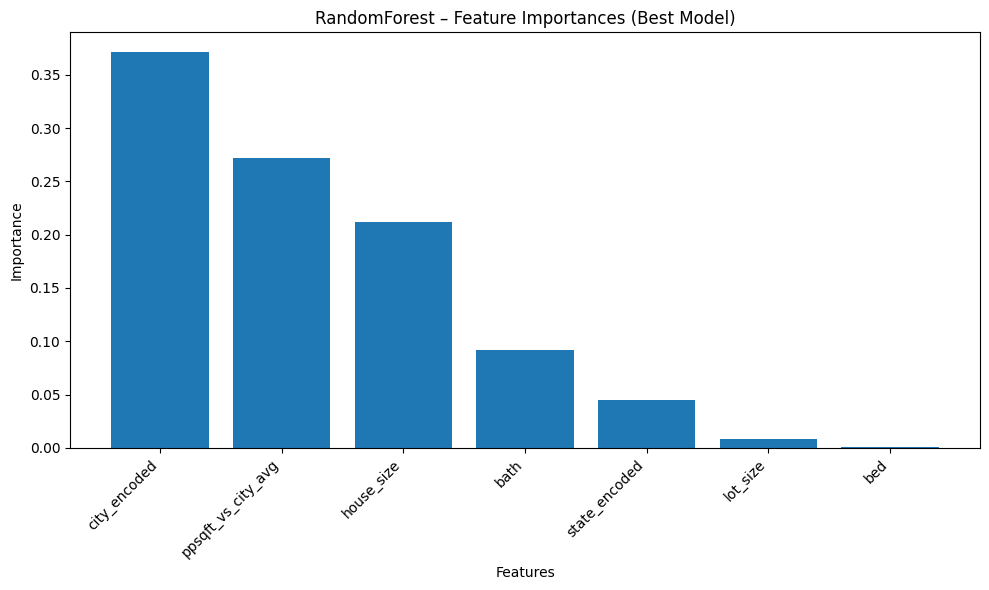


Plotting predictions vs actual for RandomForest...


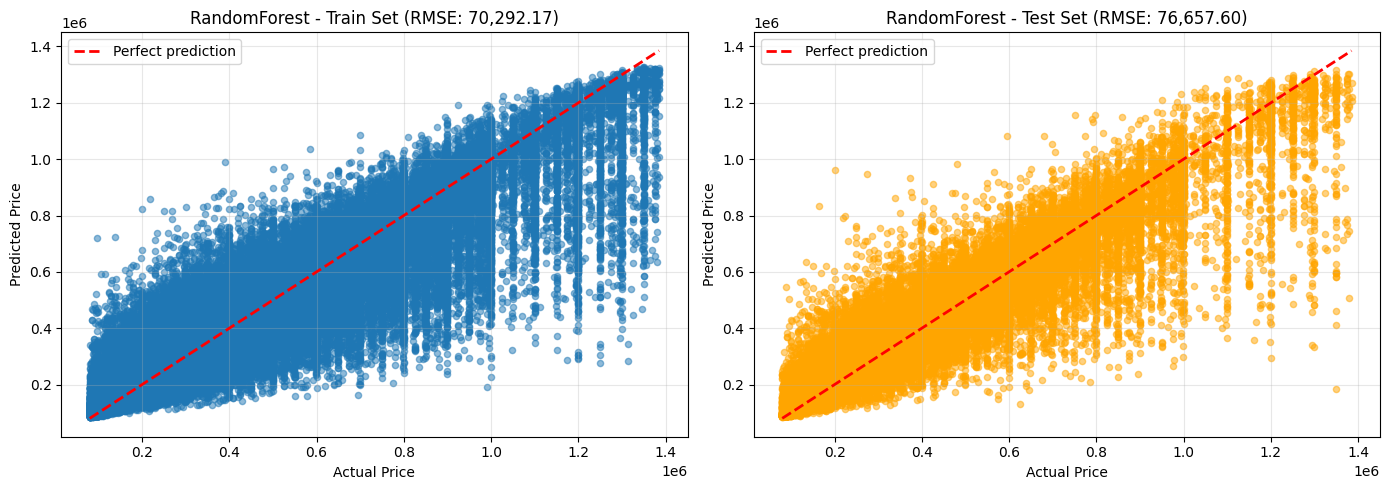



RMSE results for GradientBoosting
--------------------------------------------------
Best combination #30: {'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__n_estimators': 350}
Train RMSE: 65,321.72  Test RMSE: 75,468.72
Overfit Ratio: 1.16x, current model is a good fit

Plotting boosting iterations for the BEST GradientBoosting model...


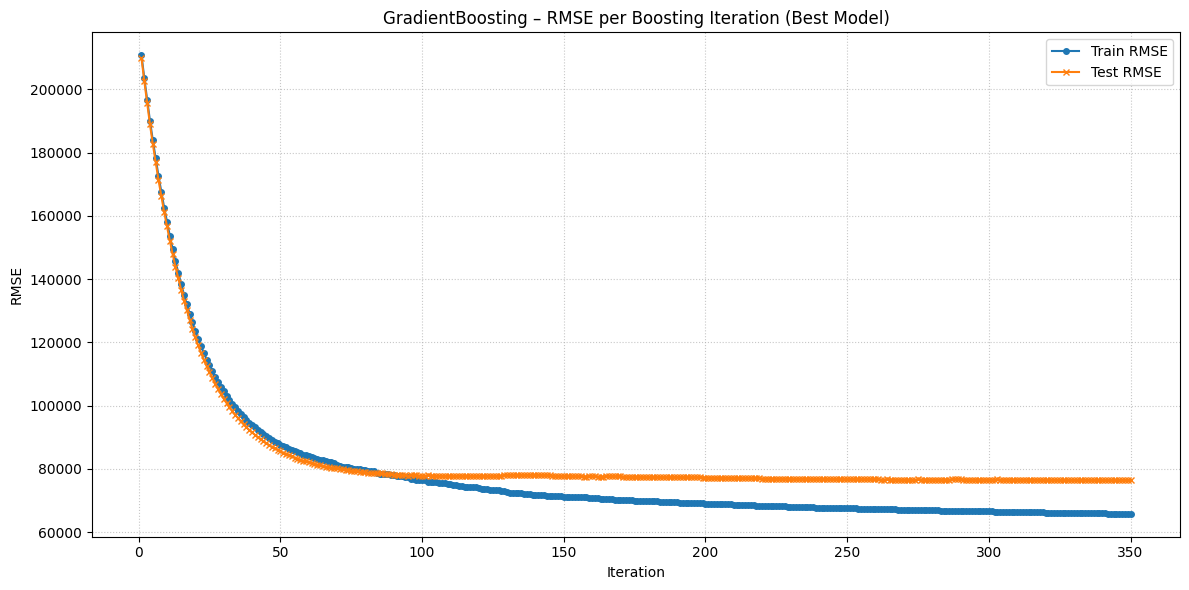



RMSE results for XGBoost
--------------------------------------------------
Best combination #27: {'model__gamma': 0.5, 'model__learning_rate': 0.07, 'model__max_depth': 5, 'model__min_child_weight': 50, 'model__n_estimators': 450, 'model__subsample': 0.8}
Train RMSE: 67,567.86  Test RMSE: 76,962.65
Overfit Ratio: 1.14x, current model is a good fit

Plotting boosting iterations for the BEST XGBoost model...


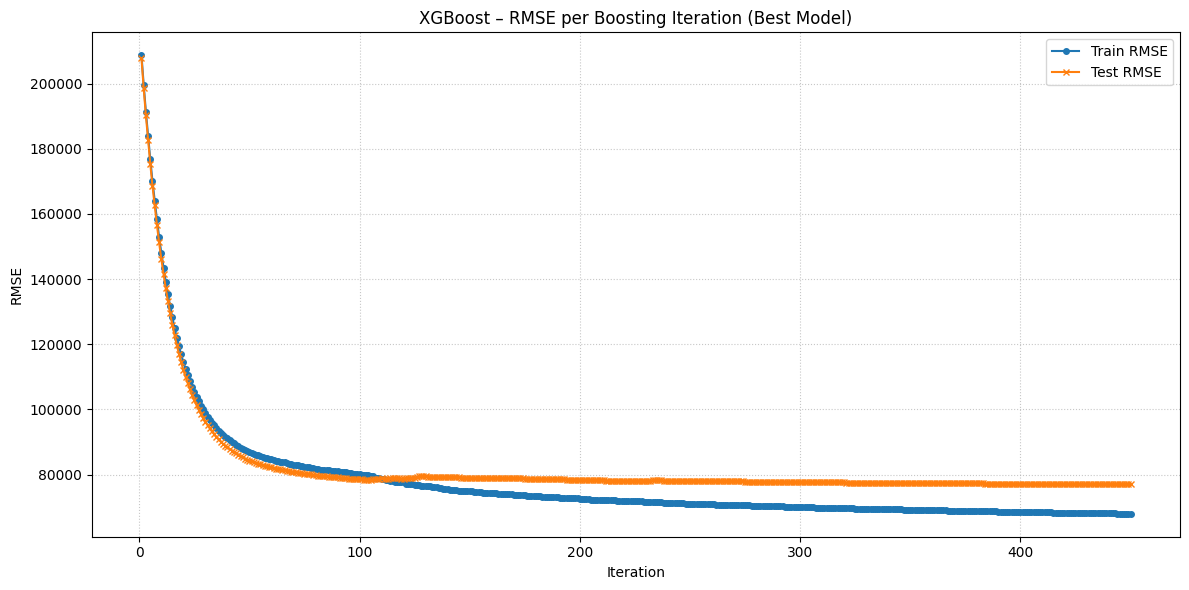

In [119]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# visualizing model performance

# checking model performance
for name, details in tuned_details.items():
    # extract arrays
    train_rmse = np.array(details['train_rmse'])
    test_rmse = np.array(details['test_rmse'])
    params = details['params']

    # best combination
    best_idx = test_rmse.argmin()
    overfit_ratio = test_rmse[best_idx] / train_rmse[best_idx]
    
    print(f"RMSE results for {name}")
    print('-'*50)
    print(f"Best combination #{best_idx + 1}: {params[best_idx]}")
    print(f"Train RMSE: {train_rmse[best_idx]:,.2f}  Test RMSE: {test_rmse[best_idx]:,.2f}")
    print(f"Overfit Ratio: {overfit_ratio:.2f}x", end=", ")

    if overfit_ratio >= 1 and overfit_ratio < 1.2:
        print("current model is a good fit")
    elif overfit_ratio >=1 and test_rmse[best_idx] < baseline_rmse:
        print("Current model is underfitting")
    elif overfit_ratio < 1.5:
        print("Current model is slightly overfitting")
    else:
        print("Current model is overfitting")

    #----------------
    best_mod = best_models[name]
    name_model = best_mod.named_steps['model']
    scaler = best_mod.named_steps['scaler']

    # scale data
    X_train_scaled = scaler.transform(X_train_final)
    X_test_scaled  = scaler.transform(X_test_final)
    
    # Plot based on model type
    if name == 'RandomForest':
        print(f"\nPlotting feature importances for {name}...")
        
        # Get feature importances
        importances = name_model.feature_importances_
        feature_names = X_train_final.columns
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.title(f"{name} – Feature Importances (Best Model)")
        plt.xlabel("Features")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
        
        # Also plot predictions vs actual
        print(f"\nPlotting predictions vs actual for {name}...")
        y_train_pred = best_mod.predict(X_train_final)
        y_test_pred = best_mod.predict(X_test_final)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Train set
        ax1.scatter(y_train_reset, y_train_pred, alpha=0.5, s=20)
        ax1.plot([y_train_reset.min(), y_train_reset.max()], 
                 [y_train_reset.min(), y_train_reset.max()], 
                 'r--', lw=2, label='Perfect prediction')
        ax1.set_xlabel('Actual Price')
        ax1.set_ylabel('Predicted Price')
        ax1.set_title(f'{name} - Train Set (RMSE: {train_rmse[best_idx]:,.2f})')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Test set
        ax2.scatter(y_test_reset, y_test_pred, alpha=0.5, s=20, color='orange')
        ax2.plot([y_test_reset.min(), y_test_reset.max()], 
                 [y_test_reset.min(), y_test_reset.max()], 
                 'r--', lw=2, label='Perfect prediction')
        ax2.set_xlabel('Actual Price')
        ax2.set_ylabel('Predicted Price')
        ax2.set_title(f'{name} - Test Set (RMSE: {test_rmse[best_idx]:,.2f})')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    elif name in ['GradientBoosting', 'XGBoost']:
        print(f"\nPlotting boosting iterations for the BEST {name} model...")

        mod_train_rmse = []
        mod_test_rmse = []
        
        if name == 'GradientBoosting':
            for y_pred_train in name_model.staged_predict(X_train_scaled):
                mod_train_rmse.append(mean_squared_error(y_train_reset, y_pred_train) ** 0.5)
            for y_pred_test in name_model.staged_predict(X_test_scaled):
                mod_test_rmse.append(mean_squared_error(y_test_reset, y_pred_test) ** 0.5)

        elif name == 'XGBoost':
            # Get the number of boosting rounds (trees) in the model
            n_estimators = name_model.n_estimators

            # Compute RMSE for each iteration
            for i in range(1, n_estimators + 1):
                # Predict using only the first i trees
                y_pred_train = name_model.predict(X_train_scaled, iteration_range=(0, i))
                y_pred_test = name_model.predict(X_test_scaled, iteration_range=(0, i))
                
                mod_train_rmse.append(np.sqrt(mean_squared_error(y_train_reset, y_pred_train)))
                mod_test_rmse.append(np.sqrt(mean_squared_error(y_test_reset, y_pred_test)))

        iterations = np.arange(1, len(mod_train_rmse) + 1)

        plt.figure(figsize=(12, 6))
        plt.plot(iterations, mod_train_rmse, marker='o', label='Train RMSE', markersize=4)
        plt.plot(iterations, mod_test_rmse, marker='x', label='Test RMSE', markersize=4)

        plt.title(f"{name} – RMSE per Boosting Iteration (Best Model)")
        plt.xlabel("Iteration")
        plt.ylabel("RMSE")
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    print("\n")

In [120]:
# Obtaining feature importance
print("Feature importance analysis")
print("-"*50)
print()

feature_names = X_train_final.columns.tolist()

for name, pipeline in best_models.items():
    print(f"\n{name} Feature Importance:")
    print("-" * 50)
    
    # Extract the model from the pipeline
    model = pipeline.named_steps['model']
    importances = model.feature_importances_
    
    # Create a DataFrame and sort by importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display all features
    print(feature_importance_df.to_string(index=False))
    print("\n")

Feature importance analysis
--------------------------------------------------


RandomForest Feature Importance:
--------------------------------------------------
           Feature  Importance
      city_encoded    0.371185
ppsqft_vs_city_avg    0.271419
        house_size    0.211553
              bath    0.091670
     state_encoded    0.044895
          lot_size    0.008546
               bed    0.000733



GradientBoosting Feature Importance:
--------------------------------------------------
           Feature  Importance
      city_encoded    0.343310
ppsqft_vs_city_avg    0.274269
        house_size    0.231402
              bath    0.081854
     state_encoded    0.061835
          lot_size    0.006734
               bed    0.000596



XGBoost Feature Importance:
--------------------------------------------------
           Feature  Importance
              bath    0.327779
        house_size    0.241861
ppsqft_vs_city_avg    0.225426
      city_encoded    0.148726
     state_

In [121]:
# Save our trained model into a pkl file
best_model_name = min(tuned_metrics, key=lambda x: tuned_metrics[x]['rmse'])
best_model = best_models[best_model_name]

with open('best_model_pipeline.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model saved successfully as 'best_model_pipeline.pkl'")

Model saved successfully as 'best_model_pipeline.pkl'


#### Testing prediction for workflow before integration with front-end and GenAI

In [1]:
import pickle
# Load the saved encoders
with open('final_city_encoder.pkl', 'rb') as file:
    loaded_city_encoder = pickle.load(file)

with open('final_state_encoder.pkl', 'rb') as file:
    loaded_state_encoder = pickle.load(file)

# load city average price per square feet dict
with open('city_avg_ppsqft.pkl', 'rb') as file:
    city_avg_lookup = pickle.load(file)

# Load the saved model pipeline
with open('best_model_pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

In [2]:
print(loaded_pipeline)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=6,
                                           min_samples_leaf=15,
                                           min_samples_split=25,
                                           n_estimators=350,
                                           random_state=42))])


In [4]:
import pandas as pd
# Example: New data (must have same columns as original X)
new_data = pd.DataFrame({
    'house_size': [2000, 1500],
    'bed': [3, 2],
    'bath': [2, 1],
    'city': ['San Francisco', 'Austin'],
    'state': ['CA', 'TX'],
    'lot_size': [5000, 4000]
})

# Step 1: Apply target encoding
new_data_encoded = new_data.copy()
new_data_encoded['city_state'] = new_data_encoded['city'].astype(str) + "_" + new_data_encoded['state'].astype(str)

# Step 2: Look up city average price per sqft
new_data_encoded['city_avg_ppsqft'] = new_data_encoded['city_state'].map(city_avg_lookup)

# Handle missing cities
sqft_for_missing_cities = sum(city_avg_lookup.values()) / len(city_avg_lookup)
new_data_encoded['city_avg_ppsqft'].fillna(sqft_for_missing_cities, inplace=True)

# Step 3: Set ppsqft_vs_city_avg to 1.0 (assumes property is priced at city average)
new_data_encoded['ppsqft_vs_city_avg'] = 1.0

# Step 2: encode city_state (pass only that column!)
new_data_encoded['city_encoded'] = loaded_city_encoder.transform(
    new_data_encoded[['city_state']])['city_state']

# Step 3: encode state (pass only that column!)
new_data_encoded['state_encoded'] = loaded_state_encoder.transform(
    new_data_encoded[['state']])['state']

# Step 7: Drop original categorical columns
new_data_final = new_data_encoded.drop(columns=['city', 'state', 'city_state', 'city_avg_ppsqft'])

# Step 8: Make predictions (pipeline handles scaling automatically)
predictions = loaded_pipeline.predict(new_data_final)

# print("Predictions:")
for i, pred in enumerate(predictions):
    print(f"House {i+1}: ${pred:,.2f}")

# new_data_encoded = new_data_encoded.drop(columns=["city"])

# new_data_encoded['state_encoded'] = loaded_state_encoder.transform(new_data_encoded)[['state']].iloc[:, 0]
# new_data_final = new_data_encoded.drop(columns=['state'])
# new_data_final['city_state'] = new_data_encoded['city'].astype(str)+"_"+new_data_encoded['state'].astype(str)

# prediction = loaded_pipeline.predict(new_data_final)

# print("Predictions:")
# for i, pred in enumerate(prediction):
#     print(f"House {i+1}: ${pred:,.2f}")
# new_data_encoded
# # new_data_encoded['state_encoded'] = loaded_state_encoder.transform(new_data)[['state']].iloc[:, 0]

# # # Step 2: Drop original categorical columns
# new_data_final = new_data_encoded.drop(columns=['city', 'state','city_state'])
# new_data_final

# # # Step 3: Make predictions (pipeline handles scaling automatically)
# predictions = loaded_pipeline.predict(new_data_final)

# # print("Predictions:")
# for i, pred in enumerate(predictions):
#     print(f"House {i+1}: ${pred:,.2f}")

House 1: $303,116.38
House 2: $230,013.09


C:\Users\jusno\AppData\Local\Temp\ipykernel_20600\3814694362.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data_encoded['city_avg_ppsqft'].fillna(sqft_for_missing_cities, inplace=True)


In [5]:
new_data_final

,house_size,bed,bath,lot_size,ppsqft_vs_city_avg,city_encoded,state_encoded
0,2000,3,2,5000,1.0,374378.968366,374378.968366
1,1500,2,1,4000,1.0,374378.968366,374378.968366


### __Conclusion__:
#### __Best Model__: XGBoost
#### __Limitations__: Random Forest was the slowest and least accurate model. Due to computing constraints we chose to train with 250 estimators instead of 300 as was originally planned. 

# User Chart Generation

# Gradio Front End 

In [6]:
# Installation
!pip install beautifulsoup4
!pip install requests

In [7]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import re
import json

Creating Web Scraping Function

In [22]:
url = 'https://www.zillow.com/homedetails/1847-Via-Encantadoras-San-Ysidro-CA-92173/17174388_zpid/?utm_campaign=zillowwebmessage&utm_medium=referral&utm_source=txtshare'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/142.0.0.0 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    "Referer": "https://google.com",
    "DNT": "1",
    'Connection': 'keep-alive',
}
session = requests.session()
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

State_abbreviations = {
    'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DE': 'Delaware','FL': 'Florida',
    'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','ME': 'Maine','MD': 'Maryland',
    'MA': 'Massachusetts','MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi','MO': 'Missouri','MT': 'Montana','NE': 'Nebraska','NV': 'Nevada',
    'NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma',
    'OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont',
    'VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming','DC': 'District of Columbia'
}

def Property_Info(url): 

    #Scraping price 
    def Hprice(url):
    
        #Scraping the price from the website and converting it to an integer 
        found_price = None

        # STRATEGY 1: Keyword Match
        # Look for ANY tag that has the word "price" anywhere in its class name.
        if not found_price:
            # re.I means Case Insensitive (matches "Price", "price", "PRICE")
            price_tags = soup.find_all(['div', 'span'], class_=re.compile(r'price', re.I))
            
            for element in price_tags:
                text = element.get_text(strip=True)
                if '$' in text and any(char.isdigit() for char in text) and len(text) < 20: 
                    found_price = text
                    break
        
        # STRATEGY 2: The "(JSON Search) Option
        # If HTML fails, we scan the raw background code for the "price" variable.
        if not found_price:
            # Look for patterns like "price":549900 or "amount":549900 in the scripts
            patterns = [
                r'"price":(\d+),',
                r'"amount":(\d+),'
            ]
            for pattern in patterns:
                match = re.search(pattern, str(soup))
                if match:
                    found_price = f"${int(match.group(1)):,}"
                    break
        
        # 5. Final Result Handling
        if not found_price:
            found_price = "Price not found (Likely Off-Market or Captcha)"
        
        final_price = int(found_price.replace('$', '').replace(',', ''))
        return final_price

    
#scraping bed, bath, housing size    
    def extract_bed_bath_hsize(url):
    
        facts = {
                'beds': 'N/A', 
                'baths': 'N/A',
                'sqft': 'N/A'
            }
        body_text = soup.get_text().replace(',', '').lower() 
            
        def find_fact(text, pattern):
            match = re.search(pattern, text)
            if match:
                return match.group(1).strip()
            return 'N/A'
        
        # look for first 5 digits and right before 'beds'. 
        facts['beds'] = find_fact(body_text, r'\d{5}(\d{1,2})\s*(bed|beds)')
        
        # 2. Search for Baths: A number
        facts['baths'] = find_fact(body_text, r'(\d+\.?\d*)\s*(bath|baths)')
        
        # 3. Search for SqFt: A number (often 3-5 digits) before 'sqft'.
        facts['sqft'] = find_fact(body_text, r'(\d+)\s*sqft')
    
        final_list = [
                int(facts['beds']) if facts['beds'] != 'N/A' else facts['beds'],          
                int(facts['baths']) if facts['baths'] != 'N/A' else facts['baths'],
                int(facts['sqft']) if facts['sqft'] != 'N/A' else facts['sqft']
            ]
        
        return final_list
    
    size_regex = re.compile(r'([\d,\.]+)\s*(Acres|lot|sqft|Square)', re.IGNORECASE)
    Land = soup.find_all('span', string=size_regex)
        
    def land_sizeft(Lands):
        land_size_sqft = None 
                   
        for element in Land:
            text = element.text.strip()
            # "-- sqft" check
            if not Land:
                return None
        
            # # if sqft or acres check ()
            sqft_match = re.match(r"([\d,.]+)\s*(Square Feet|sqft)", text, re.IGNORECASE)
            acre_match = re.match(r"([\d,.]+)\s*Acres", text, re.IGNORECASE)
        
            if sqft_match:
                land_size_sqft = float(sqft_match.group(1).replace(",", ""))
                
            elif acre_match:
                acres = float(acre_match.group(1))
                land_size_sqft = round(acres * 43560, 2)
            
            if land_size_sqft is not None:
                 break 
                     
        return land_size_sqft
        

    
        #Scraping the city
    address = (soup.find_all('h1')[0]).text
    def get_city(addresses):
        address1 = address.replace('\xa0', '')
        split_address = address1.split(',')
        state_zip = split_address[-1].strip()
        state_abbr = state_zip.split()[0]
        state_full = State_abbreviations.get(state_abbr, "Unknown State")
        city = split_address[1]

        return city, state_full
    
    def get_price_per_sqft():
        found_ppsqft = None
        price_per_sqft_pattern = re.compile(r'\$\s*(\d+(?:,\d{3})*(?:\.\d+)?)\s*/\s*sqft', re.IGNORECASE)
        
        # Search in all text elements
        all_text_elements = soup.find_all(['span', 'div', 'p'])
        for element in all_text_elements:
            text = element.get_text(strip=True)
            match = price_per_sqft_pattern.search(text)
            if match:
                # Extract the number and remove commas
                found_ppsqft = int(match.group(1).replace(',', ''))
                break

        if not found_ppsqft:
            try:
                price = Hprice(url)
                sqft = extract_bed_bath_hsize(url)[2]
                if sqft != 'N/A' and sqft > 0:
                    found_ppsqft = round(price / sqft)
            except:
                pass
        return found_ppsqft
        
    data_list = []
    Property_Dict =  {
            'Price': Hprice(url),
            'Bed': (extract_bed_bath_hsize(soup))[0],
            'Bath': (extract_bed_bath_hsize(soup))[1],
            'Hsize': (extract_bed_bath_hsize(soup))[2], 
            'Land_Size': land_sizeft(Land), 
            'City': (get_city(address))[0],
            'State': (get_city(address))[1],
            'ppsqft': get_price_per_sqft() }

    data_list.append(Property_Dict)
    df = pd.DataFrame(data_list)
    return df
Property_Info(url)

,Price,Bed,Bath,Hsize,Land_Size,City,State,ppsqft
0,695000,4,3,1913,0.19,San Ysidro,California,363


In [23]:
df_scraped = Property_Info(url)

# Actual price from Zillow
actual_price = df_scraped["Price"].iloc[0]
actual_ppsqft = df_scraped['ppsqft'].iloc[0]

# Prepare input for model
model_input = pd.DataFrame({
    "house_size": df_scraped["Hsize"],
    "bed": df_scraped["Bed"],
    "bath": df_scraped["Bath"],
    "city": df_scraped["City"],
    "state": df_scraped["State"],
    "lot_size": df_scraped["Land_Size"],
})

# Apply encoding
encoded = model_input.copy()
# Step 2: Look up city average price per sqft
encoded['city_avg_ppsqft'] = new_data_encoded['city_state'].map(city_avg_lookup)

# Handle missing cities
sqft_for_missing_cities = sum(city_avg_lookup.values()) / len(city_avg_lookup)
encoded['city_avg_ppsqft'].fillna(sqft_for_missing_cities, inplace=True)

if actual_ppsqft is not None:
    encoded['ppsqft_vs_city_avg'] = actual_ppsqft / encoded['city_avg_ppsqft']

encoded['city_state'] = encoded['city'].astype(str)+"_"+encoded['state'].astype(str)
encoded["city_encoded"] = loaded_city_encoder.transform(encoded[['city_state']])['city_state']
encoded["state_encoded"] = loaded_state_encoder.transform(encoded[['state']])['state']

pred_model = encoded.drop(columns=["city","state", 'city_state', 'city_avg_ppsqft'])

# Predict
pred_price = loaded_pipeline.predict(pred_model)[0]

# Evaluation
difference = pred_price - actual_price
pct_error = (difference / actual_price) * 100

print(f"Zillow Actual Price:   ${actual_price:,.0f}")
print(f"Model Predicted Price: ${pred_price:,.0f}")
print(f"Difference:            ${difference:,.0f}")
print(f"Percentage Error:      {pct_error:.2f}%")

Zillow Actual Price:   $695,000
Model Predicted Price: $673,207
Difference:            $-21,793
Percentage Error:      -3.14%


C:\Users\jusno\AppData\Local\Temp\ipykernel_20600\1587309222.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  encoded['city_avg_ppsqft'].fillna(sqft_for_missing_cities, inplace=True)


Creating Evaluation Function

In [ ]:
# Function to figure out difference between list price and predicted price
def prediction_model_comparison (raw_features, actual_price):
    # Step 1: Apply target encoding
    data_encoded = raw_features.copy()
    data_encoded['city_encoded'] = loaded_city_encoder.transform(raw_features)[['city']].iloc[:, 0]
    data_encoded['state_encoded'] = loaded_state_encoder.transform(raw_features)[['state']].iloc[:, 0]

    # Step 2: Drop original categorical columns
    new_data_final = data_encoded.drop(columns=['city', 'state'])

    # Step 3: Make prediction
    predicted_price = loaded_pipeline.predict(new_data_final)

    # Step 4:
    valuation = actual_price - predicted_price

Final Master Function

In [ ]:
# Function to call all other functions
def analyze_listing(zillow_url):
    # STEP 1: Scrape
    actual_price, raw_features = Property_Info(zillow_url)

    prediction_model_comparison(raw_features, actual_price)


    # # STEP 4: Visualize (Your "Separate Model")
    # chart_figure = generate_valuation_chart(P_actual, P_predicted, valuation_status)

    # summary = f"Predicted Price: ${P_predicted:,.0f}. Listing is {valuation_status:.2f}% {'Overvalued' if valuation_status > 0 else 'Undervalued'}."

    # # STEP 5: Gradio Returns
    # return chart_figure, summary

# Gradio Interface Setup
gr.Interface(fn=analyze_listing,
             inputs=gr.Textbox(label="Zillow URL"),
             outputs=[gr.Plot(), gr.Textbox()])